# Miniproject 3: From text to mental health insights.

## Predicting Suicide Thoughts Using Machine Learning and Large Language Models
### Jose A Caparros-Martin

____

**Source:** https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch/data

**Description:** The dataset is a collection of posts from the "SuicideWatch"  subreddits of the Reddit platform. The posts are collected using Pushshift API. All posts that were made to "SuicideWatch" from Dec 16, 2008(creation) till Jan 2, 2021. Non-suicide posts are collected from r/teenagers.\


[Click here to go to the main page and download the dataset](https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch/data)

***

#### 1. Libraries

In [1]:
import pandas as pd
import numpy as np

# Text processing
import emoji 
import wordninja
import re
import string
from nltk.corpus import stopwords
import spacy

# Modelling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.decomposition import PCA

# Representation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

**Describing the dataset**\
*232,074 entries*\
*3 columns (including index)*

***

#### 2. Explore the dataset


<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  2.1 Since the dataset is too big, I am going to onnly use a portion to train the model and save the rest
</div>

In [4]:
# File
file = "Suicide_Detection.csv"

# Load data, reset the index, and remove "Unnamed: 0" column, which seems to content the previous index
df = pd.read_csv(file, low_memory=False)

df = df.reset_index(drop=True)

df = df.drop(columns=['Unnamed: 0'])

print("The dataset has \033[1m%d\033[0m rows and \033[1m%d\033[0m columns" % (df.shape[0], df.shape[1]))

df.head()

The dataset has 232074 rows and 2 columns


,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide



<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  2.2 Select a portion of the dataset and save the rest for later
</div>

In [8]:
# Set random seed for reproducibility
random_seed = 55

# I will keep 150,000 rows, which is a bit more than half of the dataset
chunk_size = 150000  

# I will sample from the original dataset
chunk_df = df.sample(n=chunk_size, random_state=random_seed)

# The rest of the data (not in the chunk) is included in a different dataset
rest_df = df.drop(chunk_df.index)

# Save both datasets to separate CSV files for later use
chunk_df.to_csv("data_chunk.csv", index=False)
rest_df.to_csv("data_rest.csv", index=False)


<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  2.3 Load the smaller version of the dataset to use less memory
</div>

In [12]:
# File
file = "data_chunk.csv"

# Load data, reset the index, and remove "Unnamed: 0" column, which seems to content the previous index
df = pd.read_csv(file, low_memory=False)

print("The dataset has \033[1m%d\033[0m rows and \033[1m%d\033[0m columns" % (df.shape[0], df.shape[1]))

df.head()

The dataset has 150000 rows and 2 columns


,text,class
0,Would anyone wanna talk about anything except ...,non-suicide
1,Yo boy just got a 6.5 on his ilets exam Let's ...,non-suicide
2,This subreddit is a special place.I’ve been mi...,suicide
3,Everything is a sign that I need to dieEven be...,suicide
4,How I beat my porn addiction I squeeze it firs...,non-suicide



<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  2.4 Check if class is unbalanced
</div>

In [15]:
df['class'].value_counts(normalize=True)

class
suicide        0.50036
non-suicide    0.49964
Name: proportion, dtype: float64

**Class can be considered as balanced**


<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  2.5 Check if there are emojis in the text and decode them
</div>

In [19]:
# Function check if a string contains any emoji, using library EMOJI
def contains_emoji(text):
    return any(char in emoji.EMOJI_DATA for char in str(text))

# Copy dataframe
df_copy = df.copy()

# Check which rows in 'text' column contain emojis
df_copy['has_emoji'] = df_copy['text'].apply(contains_emoji)

# Check if any entry has emojis
any_emoji = df_copy['has_emoji'].any()
print("Any emoji in column?", any_emoji)

Any emoji in column? True



<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  2.5.1 How many rows contain emojis in the dataset
</div>

In [22]:
df_copy['has_emoji'].value_counts(normalize=True)

has_emoji
False    0.956647
True     0.043353
Name: proportion, dtype: float64


<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  2.5.2 Around 4% of the rows in the dataset contain emojis. I will decode them so the info is included in the text before vectorizing
</div>

In [24]:
df['text_decoded'] = df['text'].apply(emoji.demojize)

df.head()

,text,class,text_decoded
0,Would anyone wanna talk about anything except ...,non-suicide,Would anyone wanna talk about anything except ...
1,Yo boy just got a 6.5 on his ilets exam Let's ...,non-suicide,Yo boy just got a 6.5 on his ilets exam Let's ...
2,This subreddit is a special place.I’ve been mi...,suicide,This subreddit is a special place.I’ve been mi...
3,Everything is a sign that I need to dieEven be...,suicide,Everything is a sign that I need to dieEven be...
4,How I beat my porn addiction I squeeze it firs...,non-suicide,How I beat my porn addiction I squeeze it firs...


**Checking whether this step created NAs or empty strings**

In [26]:
print(f"Fixing potential concatenated test generated \033[1m{df['text_decoded'].isna().sum()}\033[0m NAs")
print(f"Fixing potential concantenated test generated \033[1m{(df['text_decoded'] == '').sum()}\033[0m empty strings")

Fixing potential concatenated test generated 0 NAs
Fixing potential concantenated test generated 0 empty strings



<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  2.5.3 Double check text_decoded no longer contains emojis
</div>

In [28]:
# Copy dataframe
df_copy = df.copy()

# Check which rows in 'text' column contain emojis
df_copy['has_emoji'] = df_copy['text_decoded'].apply(contains_emoji)

# Check if any entry has emojis
any_emoji = df_copy['has_emoji'].any()
print("Any emoji in column?", any_emoji)

Any emoji in column? False



<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  2.6 Fix if any concatenated word by adding spaces
</div>

In [30]:
def fix_text_debug(text):
    try:
        split_words = wordninja.split(text)
        joined = ' '.join(split_words)
        return joined
    except Exception as e:
        print(f"Error processing: {text}, error: {e}")
        return None  # no text to preserve

# Apply with debug to avoid problems or insertions of NA
df['text_fixed'] = df['text_decoded'].apply(fix_text_debug)

# Check how many rows were fixed and put them together
fixed = df[df['text_decoded'] != df['text_fixed']]

fixed.shape

(146062, 4)

**Around 4000 rows had concatenated words and were fixed**

**Checking whether this step created NAs or empty strings**

In [32]:
print(f"Fixing potential concatenated text generated \033[1m{df['text_fixed'].isna().sum()}\033[0m NAs")
print(f"Fixing potential concantenated text generated \033[1m{(df['text_fixed'] == '').sum()}\033[0m empty strings")

Fixing potential concatenated text generated 0 NAs
Fixing potential concantenated text generated 23 empty strings


**Understanding how the text that generated empty strings after applying the concatenated words script looked like**

In [34]:
empty_rows = df[df['text_fixed'] == '']
print(empty_rows[['text']]) 

                                                     text
7473    ဆိာ်သနာာနုခစတုျဟဍနည်ျြဟျာမ နညာနညမူျာ်ကအညတဋဋာာန...
13183   Привет Здравствуйте, как вы все делаете? Я про...
27830   ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎ ︎  ︎\n︎\...
30146   ｈｅｌｐ ｉ ｉｎｓｔａｌｌｅｄ ａ ｖｉｒｕｓ ｔｈａｔ ｍａｋｅｓ ｍｅ ｓｐｅａｋ ｌ...
30827                                            有点儿想死他妈的
42389   ꠸ ꫝꪖꪻꫀ ꪻꫝ꠸ᦓ ᦓꪻꪊρ꠸ᦔ ᠻꪊᥴᛕ꠸ꪀᧁ ᠻꪮꪀꪻ ꠸ ᥴꪖꪀ ᥇ꪖ᥅ꫀꪶꪗ ᥅...
48712   �̷̊́̋̎̊̇̿͗̒́͌͊̾̆́͒̃͋͛͊̄̄͌̎͗̈̓͐̈́̀̃̏̓̆͊̋̄͊̔̈̋̕̕͝...
49970   ㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤ ㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤ...
50545                          ..........................
54284   ياتيني تحول ننسحب نول ممكسًوٌ ٍتينن جمب سوخوي ...
59359   Боже, храни америку Я атеист и не согласен с э...
62326     Ś Ś Ś Ś Ś Ś Ś Ś Ś Ś Ś Ś Ś Ś Ś Ś Ś Ś Ś Ś Ś Ś Ś Ś
78971   ᜎᜉᜈᜉᜇᜄᜎᜁᜐᜊᜓᜊ᜔ᜉᜎᜂᜇᜓᜌ ᜋᜎᜋᜇᜊᜌ  ᜊᜎᜊᜇᜋᜌᜅ  ᜌᜊᜇᜐᜄ ᜃᜈᜂ...
87632   ㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤ ㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤ...
91909   Δεν θα γίνεις Έλληνας ποτέ ΔΕΝ ΘΑ ΓΙΝΕΙΣ ΕΛΛΗΝ...
98232   ⡯⡯⡾⠝⠘⠀ ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢊⠘⡮⣣⠪⠢⡑⡌ ㅤ ⠟⠝⠈⠀⠀⠀. ⠡⠀⠠⢈⠠⢐⢠...
101689        

**It is a bit of everything; non-english characters, punctuation signs only etc. Since they are only 23 rows, I will remove them, as the impact on the dataset will not be large**


<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  2.6.1 Removing rows with empty strings as they will generate problems when lematizing.
</div>

In [38]:
df = df[df['text_fixed'] != '']
df = df.reset_index(drop=True)
df.shape

(149977, 4)


<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  2.7 Continue cleaning the text using regular expressions
</div>

In [41]:
stop_words = set(stopwords.words('english'))

def clean_text_usingreg(text, remove_stopwords=False):
    # lower case
    text=text.lower()
    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # remove emails
    text = re.sub(r'\S+@\S+', '', text)
    # remove any character that is not a letter, number or basic punctuation
    text = re.sub(r'[^a-z0-9\s.,!?\'"]','',text)
    # remove any extra spaces
    text = re.sub(r'\s+',' ',text).strip() # strip removes leading and trailing 
    if remove_stopwords:
        words = text.split()
        words = [word for word in words if word not in stop_words]
        text = ' '.join(words)
    return text
        

In [43]:
# Remove stopwords for TFIDF
df['cleaned_text'] = df['text_fixed'].apply(lambda x: clean_text_usingreg(x, remove_stopwords=True))

# Keep stopwords for spacy embeddings
df['cleaned_text_no_stop_removal'] = df['text_fixed'].apply(lambda x: clean_text_usingreg(x, remove_stopwords=False))

df.to_csv("cleaned_df.csv", index=False) # save a copy
df.head()

,text,class,text_decoded,text_fixed,cleaned_text,cleaned_text_no_stop_removal
0,Would anyone wanna talk about anything except ...,non-suicide,Would anyone wanna talk about anything except ...,Would anyone wanna talk about anything except ...,would anyone wanna talk anything except us ele...,would anyone wanna talk about anything except ...
1,Yo boy just got a 6.5 on his ilets exam Let's ...,non-suicide,Yo boy just got a 6.5 on his ilets exam Let's ...,Yo boy just got a 6 5 on his i lets exam Let's...,yo boy got 6 5 lets exam let's goo ooo ooo,yo boy just got a 6 5 on his i lets exam let's...
2,This subreddit is a special place.I’ve been mi...,suicide,This subreddit is a special place.I’ve been mi...,This sub reddit is a special place I ve been m...,sub reddit special place misdiagnosed entire l...,this sub reddit is a special place i ve been m...
3,Everything is a sign that I need to dieEven be...,suicide,Everything is a sign that I need to dieEven be...,Everything is a sign that I need to die Even b...,everything sign need die even flat told stupid...,everything is a sign that i need to die even b...
4,How I beat my porn addiction I squeeze it firs...,non-suicide,How I beat my porn addiction I squeeze it firs...,How I beat my porn addiction I squeeze it firs...,beat porn addiction squeeze first rub top want...,how i beat my porn addiction i squeeze it firs...


**Checking whether these steps created NAs or empty strings**

In [45]:
print(f"Cleaning text generated \033[1m{df['cleaned_text_no_stop_removal'].isna().sum()}\033[0m NAs")
print(f"Cleaning text generated \033[1m{(df['cleaned_text_no_stop_removal'] == '').sum()}\033[0m empty strings")

Cleaning text generated 0 NAs
Cleaning text generated 0 empty strings


In [47]:
print(f"Removing nonstop words and cleaning text generated \033[1m{df['cleaned_text'].isna().sum()}\033[0m NAs")
print(f"Removing nonstop words and cleaning text generated \033[1m{(df['cleaned_text'] == '').sum()}\033[0m empty strings")

Removing nonstop words and cleaning text generated 0 NAs
Removing nonstop words and cleaning text generated 16 empty strings


**Checking how those text that yielded empty strings after applying nonstop words look like**

In [49]:
empty_rows = df[df['cleaned_text']=='']
print(empty_rows['text'])

1046                                If only you were There.
21796                                       Why?That is all
24363                                    [OTHER]OTHER Other
32603                        Why Not?Why shouldn’t I do it?
33336                                     :(again and again
43062     لقد عدت لقد عدت لقد عدت لقد عدت لقد عدت لقد عد...
54742     A. ̢ ͝ ̵ ͟ ͢ ҉̸͠ ̀͢͡ ͡ ͜ ̷̧́͢͏ ͞͡͞ ̈̓̓̏̒̄ͣ̚͏͡ ...
73641     Why’d you do itWhy’d you do it? Why’d you do i...
89624                                              We’re no
89882                                 Now what?Now what....
95799     I am ‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎‎ ‎‎‎‎‎‎‎‎‎‎‎...
124408                                    I am below you ;)
127809                         this is me when the when the
130003                         What are those What are they
135510                                     its overits over
145945                                        why?just why?
Name: text, dtype: object


**Since they are only 16 rows I will also remove them**

In [51]:
df = df[df['cleaned_text'] != '']
df = df.reset_index(drop=True)
df.shape

(149961, 6)


<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  2.8 Lematize using SpaCy for the text that will be used for TF-IDF
</div>

In [55]:
nlp = spacy.load("en_core_web_sm")
## Use the pipe to speed up the process
def lemmatize_pipe(docs):
    return [' '.join([token.lemma_ for token in doc if token.lemma_ != '-PRON-']) for doc in nlp.pipe(docs, batch_size=1000)]

df['cleaned_text_lemma'] = lemmatize_pipe(df['cleaned_text'])
df.head()

,text,class,text_decoded,text_fixed,cleaned_text,cleaned_text_no_stop_removal,cleaned_text_lemma
0,Would anyone wanna talk about anything except ...,non-suicide,Would anyone wanna talk about anything except ...,Would anyone wanna talk about anything except ...,would anyone wanna talk anything except us ele...,would anyone wanna talk about anything except ...,would anyone wanna talk anything except we ele...
1,Yo boy just got a 6.5 on his ilets exam Let's ...,non-suicide,Yo boy just got a 6.5 on his ilets exam Let's ...,Yo boy just got a 6 5 on his i lets exam Let's...,yo boy got 6 5 lets exam let's goo ooo ooo,yo boy just got a 6 5 on his i lets exam let's...,yo boy get 6 5 let exam let us goo ooo ooo
2,This subreddit is a special place.I’ve been mi...,suicide,This subreddit is a special place.I’ve been mi...,This sub reddit is a special place I ve been m...,sub reddit special place misdiagnosed entire l...,this sub reddit is a special place i ve been m...,sub reddit special place misdiagnose entire li...
3,Everything is a sign that I need to dieEven be...,suicide,Everything is a sign that I need to dieEven be...,Everything is a sign that I need to die Even b...,everything sign need die even flat told stupid...,everything is a sign that i need to die even b...,everything sign need die even flat tell stupid...
4,How I beat my porn addiction I squeeze it firs...,non-suicide,How I beat my porn addiction I squeeze it firs...,How I beat my porn addiction I squeeze it firs...,beat porn addiction squeeze first rub top want...,how i beat my porn addiction i squeeze it firs...,beat porn addiction squeeze first rub top want...


In [60]:
df.to_csv("final_cleaned_df.csv", index=False) # save a copy

***

#### 3. Visualise the data


<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  3.1 Understand the number of words and word distribution per row
</div>

In [61]:
# Create a new column for word count for the lemmatized text
df['text_length_words_lemma'] = df['cleaned_text_lemma'].apply(lambda x: len(x.split()))


# Stats
print("Max words for lemmatized text:", df['text_length_words_lemma'].max())
print("Min words for lemmatized text:", df['text_length_words_lemma'].min())
print("Average words for lemmatized text:", df['text_length_words_lemma'].mean())
print("--"*70)


# Same process for the column with nonstop removal

df['text_length_words_no_stop_removal'] = df['cleaned_text_no_stop_removal'].apply(lambda x: len(x.split()))

# Stats
print("Max words for no lemmatized text:", df['text_length_words_no_stop_removal'].max())
print("Min words for no lemmatized text:", df['text_length_words_no_stop_removal'].min())
print("Average words for no lemmatized text:", df['text_length_words_no_stop_removal'].mean())


Max words for lemmatized text: 36002
Min words for lemmatized text: 1
Average words for lemmatized text: 66.09895906268963
--------------------------------------------------------------------------------------------------------------------------------------------
Max words for no lemmatized text: 36002
Min words for no lemmatized text: 1
Average words for no lemmatized text: 138.8324364334727


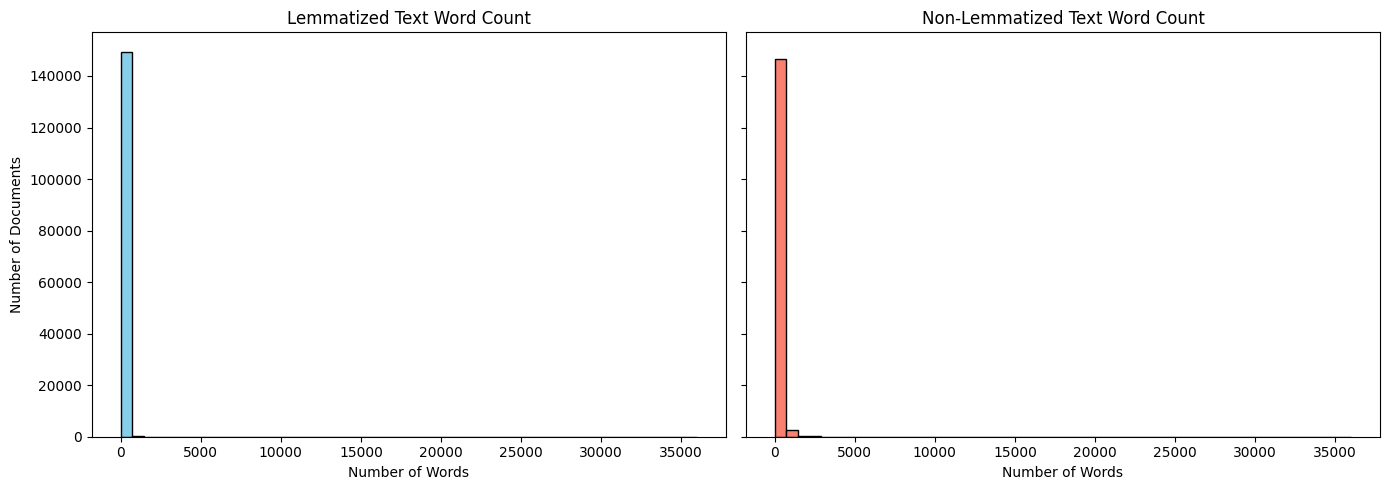

In [64]:

# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Histogram for lemmatized
axes[0].hist(df['text_length_words_lemma'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Lemmatized Text Word Count')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Number of Documents')

# Histogram for non-lemmatized
axes[1].hist(df['text_length_words_no_stop_removal'], bins=50, color='salmon', edgecolor='black')
axes[1].set_title('Non-Lemmatized Text Word Count')
axes[1].set_xlabel('Number of Words')

# Improve layout
plt.tight_layout()
plt.show()

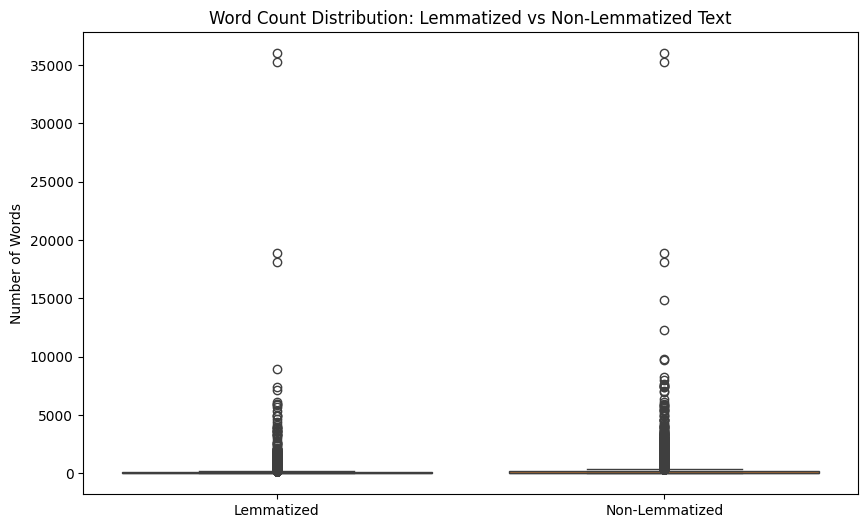

In [66]:
# Reshape the data into long format
df_long = pd.melt(
    df,
    value_vars=['text_length_words_lemma', 'text_length_words_no_stop_removal'],
    var_name='Text Type',
    value_name='Word Count'
)

# Replace column names for nicer labels
df_long['Text Type'] = df_long['Text Type'].map({
    'text_length_words_lemma': 'Lemmatized',
    'text_length_words_no_stop_removal': 'Non-Lemmatized'
})

# Plot the boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(x='Text Type', y='Word Count', data=df_long, hue='Text Type')
plt.title('Word Count Distribution: Lemmatized vs Non-Lemmatized Text')
plt.ylabel('Number of Words')
plt.xlabel('')

plt.show()

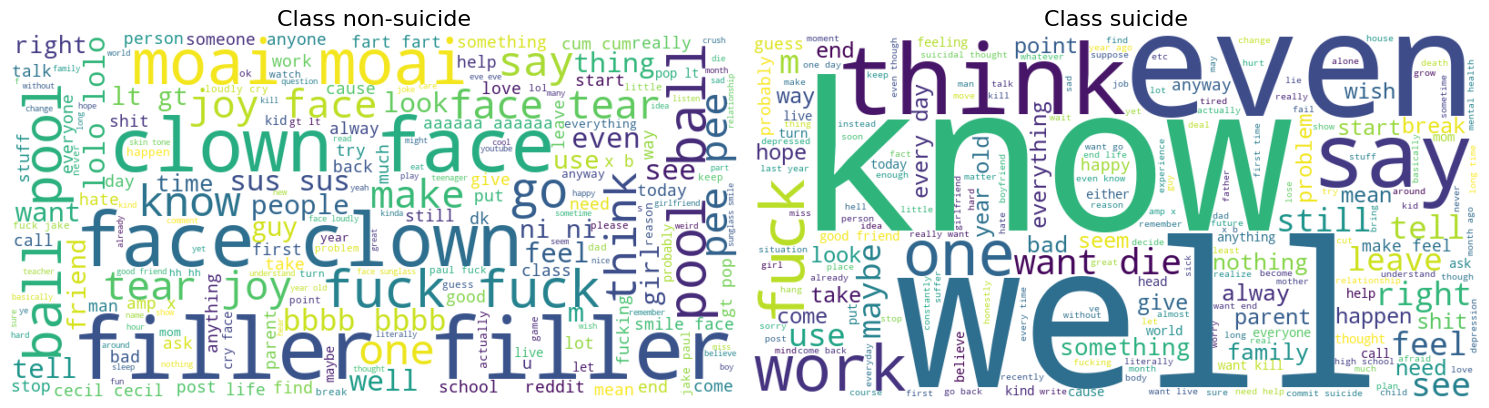

In [85]:
# Prepare a wordcloud for each class using the lemmatized column
text_column = 'cleaned_text_lemma'
label_column = 'class'

# Get unique classes
classes = df[label_column].unique()

# Set up subplots
fig, axes = plt.subplots(1, len(classes), figsize=(15, 7))

# The following ensures that if only one class, it is iterable for the loop
if len(classes) == 1:
    axes = [axes]

# Generate a word cloud for each class
for ax, cls in zip(axes, classes):
    text = ' '.join(df[df[label_column] == cls][text_column].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Class {cls}', fontsize=16)

plt.tight_layout()
plt.show()


<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  3.2 Estimating the percentage of rows with less than 500 words
</div>

In [87]:
percent_under_500 = (df['text_length_words_lemma'] < 500).mean() * 100
print(f"{percent_under_500:.2f}% of lemmatized rows have fewer than 500 words.")

percent_under_500 = (df['text_length_words_no_stop_removal'] < 500).mean() * 100
print(f"{percent_under_500:.2f}% of no lemmatized rows have fewer than 500 words.")


99.16% of lemmatized rows have fewer than 500 words.
95.26% of no lemmatized rows have fewer than 500 words.



<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  3.3 I will create two datasets. The lemmatized one will be used for TF-IDF vetorization and will be capped at 500 words. So every row with more than 500 words will be removed, which is less than 1%. The second one does not contain lemmatized words and what I will do is truncating to the first 500 words those rows with more than 500 words.
</div>

In [89]:
# Dataset retaining rows with no more than 500 words
df_tfidf = df.copy()

df_tfidf = df_tfidf[df_tfidf['text_length_words_lemma'] <= 500]

print("After removing the rows with more than 500 words the size of hte dataset is",df_tfidf.shape)

# Dataset truncating rows with more than 500 words
df_spacy = df.copy()

def truncate_text(text, max_words=500):
    words = text.split()
    if len(words) > max_words:
        return ' '.join(words[:max_words])
    else:
        return text

# Apply to the column for embeddings
df_spacy['text_truncated'] = df_spacy['cleaned_text_no_stop_removal'].apply(truncate_text)

print("After truncating to 500 words the rows with more than 500 words the size of the dataset is",df_spacy.shape)

After removing the rows with more than 500 words the size of hte dataset is (148710, 9)
After truncating to 500 words the rows with more than 500 words the size of the dataset is (149961, 10)


In [91]:
# Saves copy
df_spacy.to_csv("final_cleaned_df_spacy.csv", index=False)
df_tfidf.to_csv("final_cleaned_df_tfidf.csv", index=False)

***

#### 4. Vectorizing and modelling


<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  4.1 Encode class label and split between training and test
</div>

In [135]:

# Encode labels
df_tfidf['label_encoded'] = df_tfidf['class'].map({'non-suicide': 0, 'suicide': 1})

X=df_tfidf['cleaned_text_lemma']
y=df_tfidf['label_encoded']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)



<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  4.2 Vectorize
</div>

In [142]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2), # Take two words
    max_features=5000,
    min_df=5  # Ignore rare words
)

X_train_vector = vectorizer.fit_transform(X_train) # Learn parameters for transforming the test
X_test_vector = vectorizer.transform(X_test) 


<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  4.2.1 PCA on training
</div>

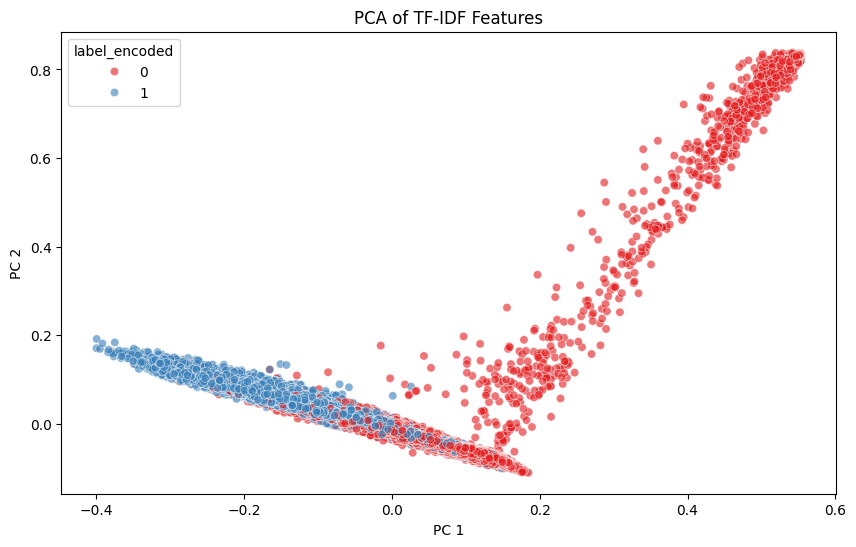

In [213]:

# Reduce to 2D
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train_vector.toarray())

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y_train, palette='Set1', alpha=0.6)
plt.title('PCA of TF-IDF Features')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  4.3 Define models and parameter grids, and run gridsearch with 3 fold CV
</div>

In [155]:
# Define models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=17),
    'RandomForest': RandomForestClassifier(random_state=17),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=17),
    'LinearSVC': LinearSVC(max_iter=10000, random_state=17)
}

# Define parameter grids
param_grids = {
    'LogisticRegression': {
        'C': [0.1, 1],
        'penalty': ['l2'],
        'solver': ['lbfgs']
    },
    'RandomForest': {
        'n_estimators': [100],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1]
    },
    'LinearSVC': {
        'C': [0.1, 1],
        'loss': ['hinge', 'squared_hinge']
    }
}


In [157]:
# Run gridsearch
best_models = {}
for name in models:
    print(f"Running GridSearchCV for {name}...")
    clf = GridSearchCV(
        estimator=models[name],
        param_grid=param_grids[name],
        scoring='roc_auc',
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    clf.fit(X_train_vector, y_train)  
    
    print(f"Best params for {name}: {clf.best_params_}")
    print(f"Best CV AUC for {name}: {clf.best_score_:.4f}")
    
    best_models[name] = clf.best_estimator_

Running GridSearchCV for LogisticRegression...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best params for LogisticRegression: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV AUC for LogisticRegression: 0.9803
Running GridSearchCV for RandomForest...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params for RandomForest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best CV AUC for RandomForest: 0.9640
Running GridSearchCV for XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/Users/Mac/Software/anaconda3/envs/spacy-env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:30:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Mac/Software/anaconda3/envs/spacy-env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:30:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Mac/Software/anaconda3/envs/spacy-env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:30:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Mac/Software/anaconda3/envs/spacy-env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:30:32] WARNING: /Users/runner/work/

Best params for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Best CV AUC for XGBoost: 0.9704
Running GridSearchCV for LinearSVC...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params for LinearSVC: {'C': 0.1, 'loss': 'squared_hinge'}
Best CV AUC for LinearSVC: 0.9806



<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  4.4 Plot learning curves
</div>

In [181]:
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, scoring='roc_auc', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5)
    )

    train_scores_mean = train_scores.mean(axis=1)
    val_scores_mean = val_scores.mean(axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training AUC')
    plt.plot(train_sizes, val_scores_mean, 'o-', label='Validation AUC')
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("AUC")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

LogisticRegression Params: {'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 17, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


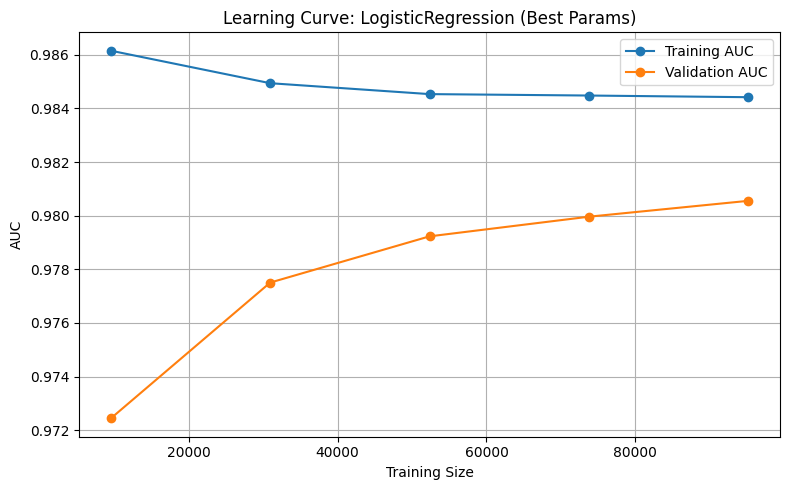

RandomForest Params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 17, 'verbose': 0, 'warm_start': False}


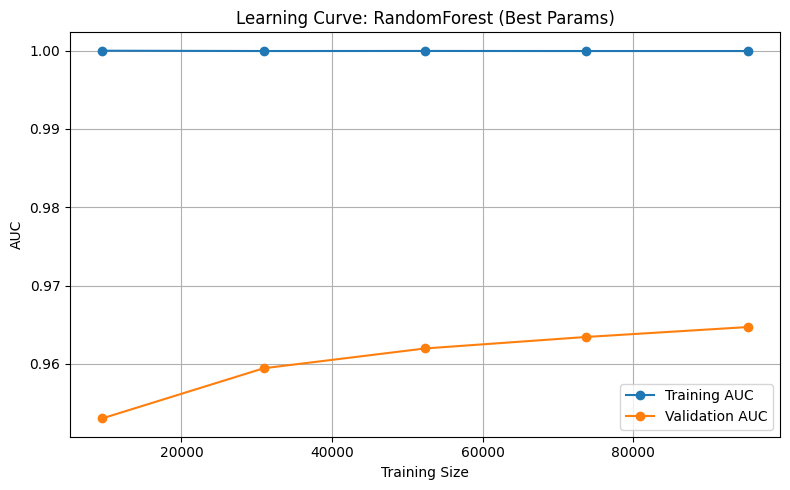

XGBoost Params: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 17, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}


/Users/Mac/Software/anaconda3/envs/spacy-env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:19:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Mac/Software/anaconda3/envs/spacy-env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:19:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Mac/Software/anaconda3/envs/spacy-env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:19:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Mac/Software/anaconda3/envs/spacy-env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:20:02] WARNING: /Users/runner/work/

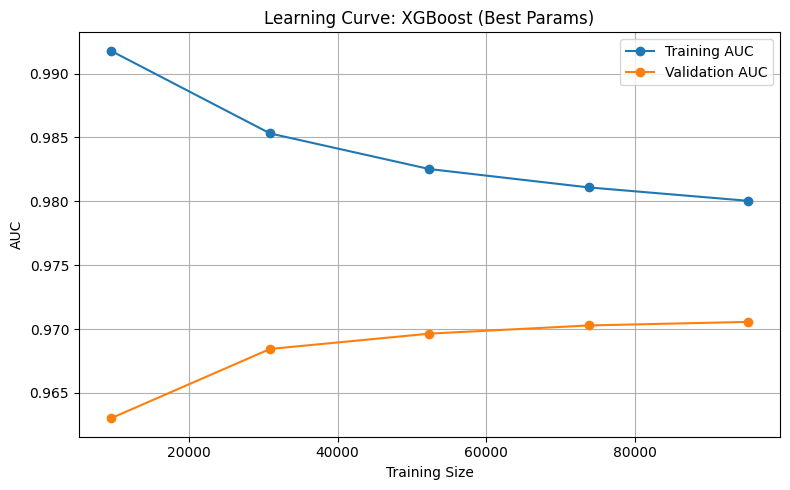

LinearSVC Params: {'C': 0.1, 'class_weight': None, 'dual': 'auto', 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 10000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 17, 'tol': 0.0001, 'verbose': 0}


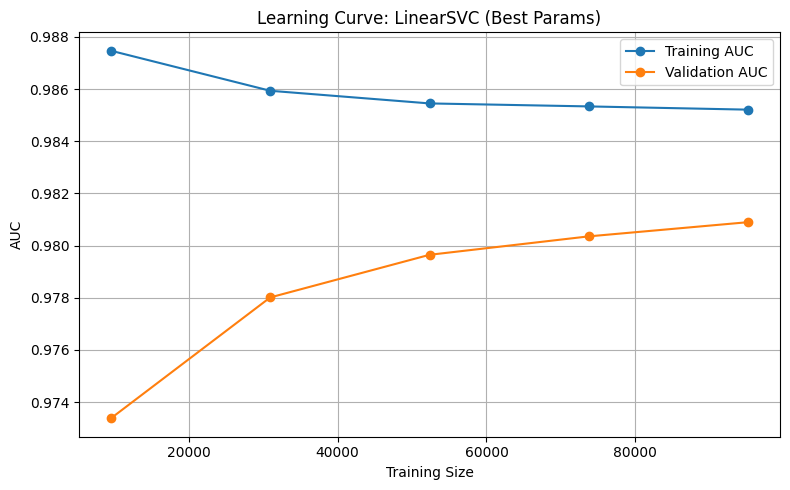

In [183]:
for name, model in best_models.items():
    title = f"Learning Curve: {name} (Best Params)"
    print(f"{name} Params: {model.get_params()}")
    plot_learning_curve(model, X_train_vector, y_train, title)

**Random forest model is overfitting**  
The rest of the models behave normally.

<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  4.5 Model metrics on training sets
</div>

In [195]:
# Store results
train_metrics = {}

for name, model in best_models.items():
    # Predict on training data
    y_train_pred = model.predict(X_train_vector)
    
    # Calculate accuracy and F1
    acc = accuracy_score(y_train, y_train_pred)
    f1 = f1_score(y_train, y_train_pred)
    
    train_metrics[name] = {
        "Accuracy": acc,
        "F1 Score": f1
    }

# Convert to DataFrame for easy viewing

train_metrics_df = pd.DataFrame(train_metrics).T
print(train_metrics_df)

                    Accuracy  F1 Score
LogisticRegression  0.940455  0.939698
RandomForest        0.998395  0.998384
XGBoost             0.926039  0.923918
LinearSVC           0.942068  0.941284


<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  4.6 Model metrics on test sets
</div>

In [200]:

# Store results
test_results = {}

for name, model in best_models.items():
    y_pred = model.predict(X_test_vector)
    
    # For ROC AUC, need predicted probabilities or decision function
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_vector)[:, 1]
    else:
        y_proba = model.decision_function(X_test_vector)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    test_results[name] = {
        "Accuracy": acc,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    }

# Convert to DataFrame for display
import pandas as pd

df_test_results = pd.DataFrame(test_results).T
print(df_test_results)


                    Accuracy  F1 Score   ROC AUC
LogisticRegression  0.933192  0.932537  0.980121
RandomForest        0.904008  0.905222  0.964347
XGBoost             0.913019  0.911017  0.970296
LinearSVC           0.934806  0.934009  0.980453


<div style="border-left: 5px solid #007BFF; background-color: #f0f8ff; padding: 15px; border-radius: 8px; color: #333;">
  <strong> </strong>  4.7 ROC AUC
</div>

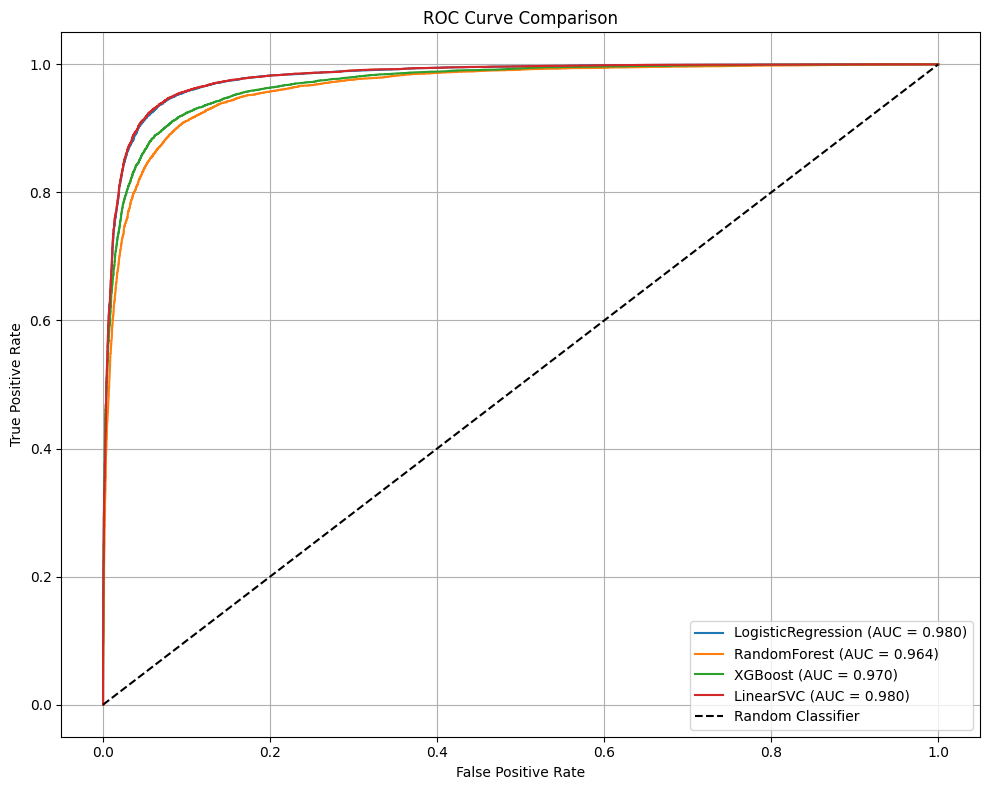

In [208]:
plt.figure(figsize=(10, 8))

for name, model in best_models.items():
    # Predict probabilities (some models use predict_proba, others decision_function)
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test_vector)[:, 1]
    else:  # for models like LinearSVC
        y_scores = model.decision_function(X_test_vector)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)
    
    # Plot
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# Plot baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Plot labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

***